In [1]:
# Imports
import torch
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm 
from sklearn import metrics

from utils.dataGen import Patches
from utils.datasets import *
from ResNet.ResNet_3D_3 import ResNet_3D as CNN, ResidualBlock

E:\Software\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count(), torch.cuda.get_device_name()

(1, 'NVIDIA RTX A4000')

In [3]:
# Hyperparameters

in_channels = 1
classes = ["background", "leaf", "diseased"]
num_classes = len(classes)
weights = [1.0, 1.0, 1.0]
rgb_bands = [7, 15, 32]
# rgb_bands = [0]
img_size = 20
learning_rate = 1e-05
lr_step = 20
batch_size = 128
num_epochs = 50
frac = .7
save_dataset = True
augment = True
count = True
kfold = 1

In [4]:
# Initialize network

# model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)
# model = ResNet(ResidualBlock, [2, 2, 2, 2], initial_inplanes = 55).to(device)
model = CNN(ResidualBlock).to(device)
print("Num of trainable param:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Num of trainable param: 16587075


In [5]:
# Loss and optimizer

class_weights = torch.FloatTensor(weights).cuda()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=0.1)

In [6]:
# Init dataset

p_14 = Patches("D:\\gyeongsang_22_10_14\\PATCHES\\STACK_75_BANDS_14")
p_14_h = Patches("D:\\gyeongsang_22_10_14\\PATCHES\\STACK_75_BANDS_14_5")
p_21 = Patches("D:\\gyeongsang_22_10_21_1\\PATCHES\\STACK_75_BANDS_21_1_2")
p_25_h = Patches("D:\\gyeongsang_22_10_25\\PATCHES\\STACK_75_BANDS_25_3")
p_25 = Patches("D:\\gyeongsang_22_10_25\\PATCHES\\STACK_75_BANDS_25")
p_28 = Patches("D:\\gyeongsang_22_10_28\\PATCHES\\STACK_75_BANDS_28")
p_28_h = Patches("D:\\gyeongsang_22_10_28\\PATCHES\\STACK_75_BANDS_28_healthy")

In [7]:
print(p_14.describe(),
      p_14_h.describe(),
      p_21.describe(),
      p_25_h.describe(),
      p_25.describe(),
      p_28.describe(),
      p_28_h.describe())

For hdr image, there are: 
 leaf          5160
background    4369
diseased       215
Name: class, dtype: int64 

For hdr image, there are: 
 leaf          1731
background     597
diseased       173
Name: class, dtype: int64 

For hdr image, there are: 
 background    575
leaf          338
diseased       61
Name: class, dtype: int64 

For hdr image, there are: 
 leaf    148
Name: class, dtype: int64 

For hdr image, there are: 
 leaf          663
background    650
diseased      117
Name: class, dtype: int64 

For hdr image, there are: 
 background    1148
leaf           710
diseased        96
Name: class, dtype: int64 

For hdr image, there are: 
 leaf    271
Name: class, dtype: int64 

None None None None None None None


In [8]:
# Get dataset

patch_14_hd = p_14_h.getDataset([40, 1725, 173])
patch_14_b  = p_14.getDataset([150, 0, 0])
patch_14    = [pd.concat([patch_14_hd[0], patch_14_b[0]]),
               pd.concat([patch_14_hd[1], patch_14_b[1]])]

patch_21    = p_21.getDataset([150, 0, 61])

patch_25 = p_25.getDataset([100, 0, 117])
# patch_25_h  = p_25_h.getDataset([0, 0, 0])
# patch_25    = [pd.concat([patch_25_bd[0], patch_25_h[0]]),
#                pd.concat([patch_25_bd[1], patch_25_h[1]])]

patch_28    = p_28.getDataset([100, 0, 96])

# Shuffle dataset

def shuffle(patch):
    return [patch[i].sample(frac=1) for i in range(len(patch))]

patch_14 = shuffle(patch_14)
patch_21 = shuffle(patch_21)
patch_25 = shuffle(patch_25)
patch_28 = shuffle(patch_28)

Training set has 1357 samples [0 1 2] class indices included
Validation set has 581 samples [0 1 2] class indices included
   Example: D:\gyeongsang_22_10_14\PATCHES\STACK_75_BANDS_14_5\hdr\background\88_267.HDR
   Unique: True


Training set has 105 samples [0] class indices included
Validation set has 45 samples [0] class indices included
   Example: D:\gyeongsang_22_10_14\PATCHES\STACK_75_BANDS_14\hdr\background\101_374.HDR
   Unique: True


Training set has 148 samples [0 2] class indices included
Validation set has 63 samples [0 2] class indices included
   Example: D:\gyeongsang_22_10_21_1\PATCHES\STACK_75_BANDS_21_1_2\hdr\background\81_282.HDR
   Unique: True


Training set has 152 samples [0 2] class indices included
Validation set has 65 samples [0 2] class indices included
   Example: D:\gyeongsang_22_10_25\PATCHES\STACK_75_BANDS_25\hdr\background\52_399.HDR
   Unique: True


Training set has 137 samples [0 2] class indices included
Validation set has 59 samples [0 2] class i

In [9]:
def splitDatasetKfold(patch, kfold, dtype='hdr', train_frac=0.7):   
    patch_kfold = []
    kfold_recs  = patch.copy()
    
    for k in range(kfold):
        tr = pd.DataFrame(columns=["path", "type", "class"])
        vl = tr.copy()
        for i in range(num_classes):
            tmp = patch.loc[(patch['class'] == i) & 
                             (patch['type'] == dtype)]
            tmp_tr = tmp.sample(frac=train_frac, replace=False, random_state=k)
            tmp_vl = tmp.drop(tmp_tr.index)

            tr = pd.concat([tr, tmp_tr])
            vl = pd.concat([vl, tmp_vl])
            
        kfold_recs.loc[tr.index, f'k{k}'] = 0
        kfold_recs.loc[vl.index, f'k{k}'] = 1
            
        patch_kfold.append([tr, vl])

    # print((kfold_recs.loc[:, [f'k{i}' for i in range(kfold)]].sum(axis=1) == 0).sum())
    
    return patch_kfold, kfold_recs

In [10]:
# patch_14_kfold, kfold_recs = splitDatasetKfold(patch_14, kfold)
# len(patch_14_kfold)

In [11]:
# Patch wrapper

img_14 = wrapPatch(patch_14)
img_21 = wrapPatch(patch_21)
img_25 = wrapPatch(patch_25)
img_28 = wrapPatch(patch_28)

patch_21_25_28 = pd.concat([patch_21[0], patch_25[0], patch_28[0]])
train_patch = pd.concat([patch_14[0], patch_21[0], patch_25[0], patch_28[0]])
val_patch = pd.concat([patch_14[1], patch_21[1], patch_25[1], patch_28[1]])

patch_21_25_28 = patch_21_25_28.sample(frac=1)
train_patch = train_patch.sample(frac=1)
val_patch = val_patch.sample(frac=1)

In [12]:
# Define training images

img_21_25_28 = wrapPatch(patch_21_25_28)
train_img = wrapPatch(train_patch)
val_img = wrapPatch(val_patch)

if count:
    countImg(train_img, classes)
    countImg(val_img, classes)

if save_dataset:
    train_img.img_df.to_csv("train.csv")
    val_img.img_df.to_csv("val.csv")

1899, with {'background': 378, 'leaf': 1208, 'diseased': 313}
813, with {'background': 162, 'leaf': 517, 'diseased': 134}


In [13]:
# Augment images 

if augment:
    train_img_aug1 = augmentPatch2(img_21_25_28, [0, 0, 3], ["Training set 21, 25 and 28"])
    train_img_aug2 = augmentPatch2(img_14[0], [0, 0, 3], ["Training set 14"])
    
    train_img = ConcatDataset([train_img] + train_img_aug1 + train_img_aug2)
    val_img = ConcatDataset([val_img])   
    
    if count:
        countImg(train_img, classes)
        countImg(val_img, classes)

Training set 21, 25 and 28
class index: 2
	 Rotated 90 deg
	 Rotated 180 deg
	 Rotated 270 deg
Training set 14
class index: 2
	 Rotated 90 deg
	 Rotated 180 deg
	 Rotated 270 deg
2838, with {'background': 378, 'leaf': 1208, 'diseased': 1252}
813, with {'background': 162, 'leaf': 517, 'diseased': 134}


In [14]:
# Load images

loaders = imagesLoader([[train_img, True ],
                        [val_img  , False],
                        [img_14[1], False],
                        [img_21[1], False],
                        [img_25[1], False],
                        [img_28[1], False]], batch_size)

train_loader = loaders[0]
test_loader = loaders[1]

next(iter(train_loader))[0].shape

torch.Size([128, 1, 55, 20, 20])

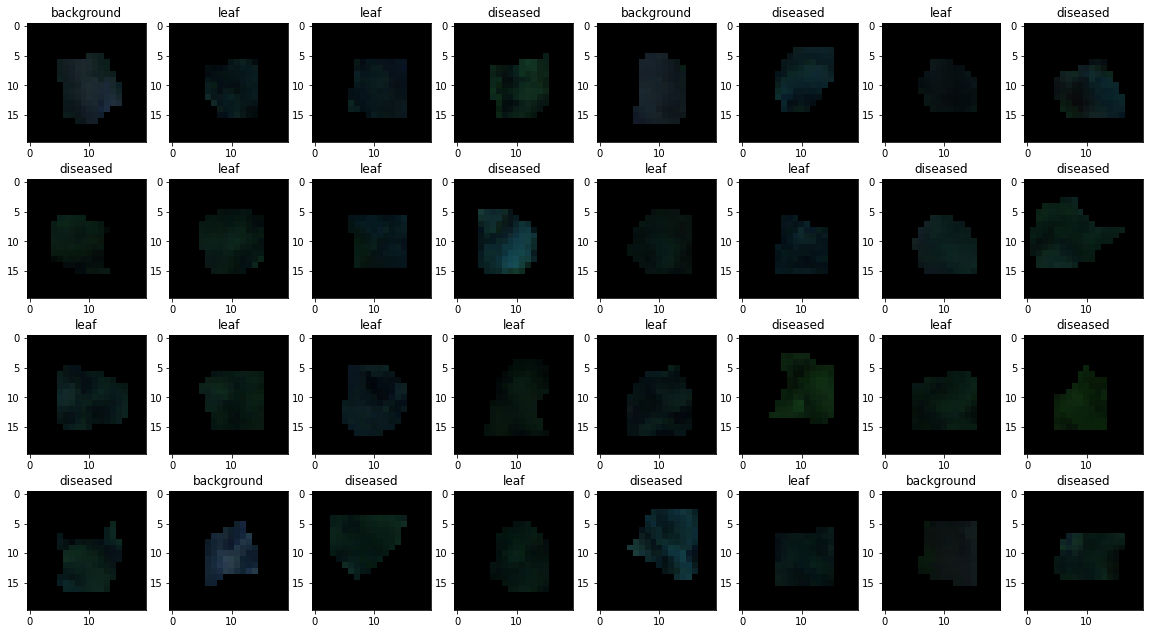

In [15]:
# Check the images

for train_sample in train_loader:
   displayImgs(train_sample[0], train_sample[1], classes=classes, n=batch_size)
   break

In [16]:
# Check the model

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x_ = model(x)
        print(x_[0])
        break

tensor([ 0.2593,  0.5514, -0.6946], device='cuda:0')


In [17]:
# Evaluate the model

def evaluate(loader, model):
    actuals = np.array([])
    predictions = np.array([])
    evaluations = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, model_pred = scores.max(1)
            actuals = np.append(actuals, y.cpu().detach().numpy())
            predictions = np.append(predictions, model_pred.cpu().detach().numpy())
    
    for i in range(num_classes):
        ac = (actuals == i)
        pr = (predictions == i)

        ca = (ac & pr).sum() / ac.sum()
        evaluations = np.append(evaluations, ca)
        
    oa = (actuals == predictions).sum() / len(actuals)
    evaluations = np.append(evaluations, oa)
    
    model.train()

    return evaluations

print(evaluate(train_loader, model), evaluate(test_loader, model))

[1.         0.         0.         0.13319239] [1.         0.         0.         0.19926199]


In [18]:
def evaluateTorch(loader, model):
    actuals = []
    predictions = []
    evaluations = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, model_pred = scores.max(1)
            
            actuals.append(y)
            predictions.append(model_pred)
            
    actuals = torch.cat(actuals)
    predictions = torch.cat(predictions)
    
    for i in range(num_classes):
        ac = (actuals == i)
        pr = (predictions == i)

        ca = (ac & pr).sum() / ac.sum()
        evaluations.append(ca)

    oa = (actuals == predictions).sum() / len(actuals)
    evaluations.append(oa)
    
    model.train()

    return [e.item() for e in evaluations]

print(evaluateTorch(train_loader, model), evaluateTorch(test_loader, model))

[1.0, 0.0, 0.0, 0.13319239020347595] [1.0, 0.0, 0.0, 0.19926199316978455]


In [19]:
# Make a list to record training progress

eval_ent = [train_loader, test_loader, loaders[2]]
eval_hist = [[[] for i in range(2 + num_classes)]for i in range(len(eval_ent))]
eval_idx = 1
highest_acc = 0
highest_dis = 0

b_oa = 0
b_d = 0
trained_epochs = 0

In [ ]:
# Train the network

for epoch in range(num_epochs):
    batch_loss = np.array([])
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        predictions = torch.argmax(scores, dim=1)
               
        loop.set_description(f"Epoch[{epoch}/{num_epochs - 1}]")
        
        batch_loss = np.append(batch_loss, loss.item())
    
    scheduler.step()
    eval_hist[0][0].append(np.average(batch_loss))
    print("loss: ", eval_hist[0][0][-1])
    
    for ee, eh in zip(eval_ent, eval_hist):
        ev = evaluateTorch(ee, model)
        for i in range(len(ev)):
            eh[i + 1].append(ev[i])
     
    c_acc = eval_hist[eval_idx][-1][-1]
    d_acc = eval_hist[eval_idx][2 + 1][-1]
    p_acc = highest_acc
    
    if (c_acc > highest_acc):
        print(f"Best OA is on {epoch} epoch") 
        torch.save(model.state_dict(), os.getcwd() + f"\\ResNet3D_노균병_OA{epoch}_best.pt")
        highest_acc = c_acc
        b_oa = epoch
        
    if (((abs(c_acc - p_acc) < 6) or (c_acc > p_acc)) and (d_acc > highest_dis)):
        print(f"Best diseased accuracy is on {epoch} epoch") 
        torch.save(model.state_dict(), os.getcwd() + f"\\ResNet3D_노균병_d{epoch}_best.pt")
        b_d = epoch
        if c_acc > 0.8:
            highest_dis = d_acc
    
    print(optimizer.param_groups[0]['lr'])   
    trained_epochs = epoch
    for i in range(num_classes + 1):
        print(f"accuracy_{i}: {eval_hist[0][i + 1][-1]}, {eval_hist[1][i + 1][-1]}, {eval_hist[2][i + 1][-1]}")
        # print(f"accuracy_{i}: {eval_hist[0][i + 1][-1]}")

Epoch[0/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:40<00:00,  1.77s/it]


loss:  0.6009437986042189
Best OA is on 0 epoch
1e-05
accuracy_0: 1.0, 1.0, 1.0
accuracy_1: 0.0, 0.0, 0.0
accuracy_2: 0.0, 0.0, 0.0
accuracy_3: 0.13319239020347595, 0.19926199316978455, 0.09105431288480759


Epoch[1/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:39<00:00,  1.70s/it]


loss:  0.4106793299965236
Best OA is on 1 epoch
Best diseased accuracy is on 1 epoch
1e-05
accuracy_0: 1.0, 1.0, 1.0
accuracy_1: 0.12334436923265457, 0.10058026760816574, 0.10058026760816574
accuracy_2: 0.09504792094230652, 0.007462686393409967, 0.0
accuracy_3: 0.2276250720024109, 0.26445263624191284, 0.1741214096546173


Epoch[2/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.2990047180134317
Best OA is on 2 epoch
Best diseased accuracy is on 2 epoch
1e-05
accuracy_0: 0.9603174328804016, 0.9506173133850098, 0.9649122953414917
accuracy_1: 0.9586092829704285, 0.9593810439109802, 0.9593810439109802
accuracy_2: 0.7507987022399902, 0.2014925330877304, 0.09615384787321091
accuracy_3: 0.8671599626541138, 0.8327183127403259, 0.8881788849830627


Epoch[3/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.2594578939935435
Best OA is on 3 epoch
Best diseased accuracy is on 3 epoch
1e-05
accuracy_0: 0.9338624477386475, 0.9320987462997437, 0.9649122953414917
accuracy_1: 0.9395695328712463, 0.9206963181495667, 0.9206963181495667
accuracy_2: 0.8905750513076782, 0.60447758436203, 0.4038461446762085
accuracy_3: 0.9171951413154602, 0.8708487153053284, 0.8817891478538513


Epoch[4/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


loss:  0.2388225443985151
1e-05
accuracy_0: 0.920634925365448, 0.9012345671653748, 0.8947368264198303
accuracy_1: 0.9751655459403992, 0.9806576371192932, 0.9806576371192932
accuracy_2: 0.835463285446167, 0.34328359365463257, 0.13461539149284363
accuracy_3: 0.9062719941139221, 0.8597785830497742, 0.9025558829307556


Epoch[5/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.22161629634058994
Best OA is on 5 epoch
Best diseased accuracy is on 5 epoch
1e-05
accuracy_0: 0.9259259104728699, 0.9135802388191223, 0.9122806787490845
accuracy_1: 0.9511589407920837, 0.9206963181495667, 0.9206963181495667
accuracy_2: 0.9345048069953918, 0.7238805890083313, 0.557692289352417
accuracy_3: 0.9404509663581848, 0.8868388533592224, 0.889776349067688


Epoch[6/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


loss:  0.23228637841732605
1e-05
accuracy_0: 0.9523809552192688, 0.9259259104728699, 0.9473684430122375
accuracy_1: 0.9652317762374878, 0.9516441226005554, 0.9516441226005554
accuracy_2: 0.9033546447753906, 0.5298507213592529, 0.21153846383094788
accuracy_3: 0.9362226724624634, 0.876998782157898, 0.889776349067688


Epoch[7/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.17654628339021103
Best diseased accuracy is on 7 epoch
1e-05
accuracy_0: 0.9788359999656677, 0.9506173133850098, 0.9649122953414917
accuracy_1: 0.9321191906929016, 0.8897485733032227, 0.8897485733032227
accuracy_2: 0.9528753757476807, 0.7761194109916687, 0.6538461446762085
accuracy_3: 0.9474982023239136, 0.8831487894058228, 0.8769968152046204


Epoch[8/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.17033595041088437
1e-05
accuracy_0: 0.9153439402580261, 0.8888888955116272, 0.8947368264198303
accuracy_1: 0.9834437370300293, 0.9806576371192932, 0.9806576371192932
accuracy_2: 0.9049520492553711, 0.5223880410194397, 0.17307692766189575
accuracy_3: 0.9397462606430054, 0.8868388533592224, 0.9057508111000061


Epoch[9/49]: 100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.1626773670963619
Best diseased accuracy is on 9 epoch
1e-05
accuracy_0: 0.9470899701118469, 0.9135802388191223, 0.9298245906829834
accuracy_1: 0.9503311514854431, 0.9032881855964661, 0.9032881855964661
accuracy_2: 0.9720447063446045, 0.7910447716712952, 0.6153846383094788
accuracy_3: 0.9594784379005432, 0.8868388533592224, 0.8817891478538513


Epoch[10/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.1347599967342356
Best OA is on 10 epoch
1e-05
accuracy_0: 0.9656084775924683, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9793046116828918, 0.9593810439109802, 0.9593810439109802
accuracy_2: 0.9464856386184692, 0.611940324306488, 0.2884615361690521
accuracy_3: 0.96300208568573, 0.8966789245605469, 0.9025558829307556


Epoch[11/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.12118783593177795
1e-05
accuracy_0: 0.9497354626655579, 0.9135802388191223, 0.9298245906829834
accuracy_1: 0.9809602499008179, 0.9400386810302734, 0.9400386810302734
accuracy_2: 0.9672523736953735, 0.6716417670249939, 0.3461538553237915
accuracy_3: 0.9707540273666382, 0.8905289173126221, 0.889776349067688


Epoch[12/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:39<00:00,  1.70s/it]


loss:  0.10858546731912572
1e-05
accuracy_0: 0.9391534328460693, 0.9074074029922485, 0.9122806787490845
accuracy_1: 0.9834437370300293, 0.9264990091323853, 0.9264990091323853
accuracy_2: 0.9776358008384705, 0.7238805890083313, 0.4038461446762085
accuracy_3: 0.9749823212623596, 0.8892988562583923, 0.8817891478538513


Epoch[13/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.12396200114618176
Best OA is on 13 epoch
1e-05
accuracy_0: 0.9894179701805115, 0.9444444179534912, 0.9473684430122375
accuracy_1: 0.9817880988121033, 0.9535783529281616, 0.9535783529281616
accuracy_2: 0.9648562073707581, 0.6268656849861145, 0.3076923191547394
accuracy_3: 0.9753347039222717, 0.8979089856147766, 0.8993610143661499


Epoch[14/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.08992356061935425
Best OA is on 14 epoch
1e-05
accuracy_0: 0.9814814925193787, 0.9320987462997437, 0.9298245906829834
accuracy_1: 0.9900662302970886, 0.9613152742385864, 0.9613152742385864
accuracy_2: 0.9736421704292297, 0.641791045665741, 0.3076923191547394
accuracy_3: 0.9816771745681763, 0.9028289914131165, 0.9041533470153809


Epoch[15/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.08924342643307603
1e-05
accuracy_0: 0.976190447807312, 0.9259259104728699, 0.9298245906829834
accuracy_1: 0.9942052960395813, 0.9767891764640808, 0.9767891764640808
accuracy_2: 0.9568690061569214, 0.5895522236824036, 0.21153846383094788
accuracy_3: 0.9753347039222717, 0.9028289914131165, 0.9089456796646118


Epoch[16/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.06485402681257414
1e-05
accuracy_0: 0.9894179701805115, 0.9382715821266174, 0.9473684430122375
accuracy_1: 0.9950330853462219, 0.988394558429718, 0.988394558429718
accuracy_2: 0.8905750513076782, 0.41791045665740967, 0.057692307978868484
accuracy_3: 0.948202908039093, 0.8843788504600525, 0.9073482155799866


Epoch[17/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.06227742184115493
Best diseased accuracy is on 17 epoch
1e-05
accuracy_0: 0.9973545074462891, 0.9444444179534912, 0.9473684430122375
accuracy_1: 0.9693708419799805, 0.8549323081970215, 0.8549323081970215
accuracy_2: 0.995207667350769, 0.858208954334259, 0.7115384340286255
accuracy_3: 0.9844960570335388, 0.8733087182044983, 0.8514376878738403


Epoch[18/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.06052799725338169
Best diseased accuracy is on 18 epoch
1e-05
accuracy_0: 0.9920634627342224, 0.9259259104728699, 0.9473684430122375
accuracy_1: 0.8998344540596008, 0.7736943960189819, 0.7736943960189819
accuracy_2: 0.9984025359153748, 0.9328358173370361, 0.8846153616905212
accuracy_3: 0.9556025266647339, 0.830258309841156, 0.7987220287322998


Epoch[19/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.05867212727341963
1.0000000000000002e-06
accuracy_0: 0.9788359999656677, 0.9135802388191223, 0.9298245906829834
accuracy_1: 0.9975165724754333, 0.9400386810302734, 0.9400386810302734
accuracy_2: 0.9960063695907593, 0.7238805890083313, 0.4038461446762085
accuracy_3: 0.9943621754646301, 0.8991389870643616, 0.894568681716919


Epoch[20/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.0355429787836645
1.0000000000000002e-06
accuracy_0: 0.9920634627342224, 0.9382715821266174, 0.9473684430122375
accuracy_1: 0.996688723564148, 0.9497098922729492, 0.9497098922729492
accuracy_2: 0.995207667350769, 0.6716417670249939, 0.3461538553237915
accuracy_3: 0.9954192638397217, 0.9015989899635315, 0.8993610143661499


Epoch[21/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.03458707026489403
1.0000000000000002e-06
accuracy_0: 0.9947090148925781, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.996688723564148, 0.9400386810302734, 0.9400386810302734
accuracy_2: 0.9960063695907593, 0.7089552283287048, 0.38461539149284363
accuracy_3: 0.9961239695549011, 0.9003689885139465, 0.894568681716919


Epoch[22/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.03229261521735917
1.0000000000000002e-06
accuracy_0: 0.9947090148925781, 0.9382715821266174, 0.9473684430122375
accuracy_1: 0.996688723564148, 0.9303675293922424, 0.9303675293922424
accuracy_2: 0.9960063695907593, 0.7014925479888916, 0.38461539149284363
accuracy_3: 0.9961239695549011, 0.894218921661377, 0.8865814805030823


Epoch[23/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.03077657419540312
1.0000000000000002e-06
accuracy_0: 0.9947090148925781, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.996688723564148, 0.9477756023406982, 0.9477756023406982
accuracy_2: 0.9960063695907593, 0.6865671873092651, 0.3461538553237915
accuracy_3: 0.9961239695549011, 0.9015989899635315, 0.8977635502815247


Epoch[24/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


loss:  0.03370204130592554
1.0000000000000002e-06
accuracy_0: 0.9947090148925781, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9975165724754333, 0.9477756023406982, 0.9477756023406982
accuracy_2: 0.9976038336753845, 0.6940298676490784, 0.36538460850715637
accuracy_3: 0.9971810579299927, 0.9028289914131165, 0.8993610143661499


Epoch[25/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:39<00:00,  1.70s/it]


loss:  0.031476435656456844
Best OA is on 25 epoch
1.0000000000000002e-06
accuracy_0: 0.9947090148925781, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.998344361782074, 0.9535783529281616, 0.9535783529281616
accuracy_2: 0.9968051314353943, 0.6791045069694519, 0.3461538553237915
accuracy_3: 0.9971810579299927, 0.9040590524673462, 0.9025558829307556


Epoch[26/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


loss:  0.02822651932744876
1.0000000000000002e-06
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.996688723564148, 0.9323017597198486, 0.9323017597198486
accuracy_2: 0.9976038336753845, 0.7089552283287048, 0.36538460850715637
accuracy_3: 0.9975334405899048, 0.8954489231109619, 0.8865814805030823


Epoch[27/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


loss:  0.028014002691792404
1.0000000000000002e-06
accuracy_0: 0.9973545074462891, 0.9259259104728699, 0.9473684430122375
accuracy_1: 0.9975165724754333, 0.9323017597198486, 0.9323017597198486
accuracy_2: 0.9976038336753845, 0.7089552283287048, 0.38461539149284363
accuracy_3: 0.9975334405899048, 0.894218921661377, 0.8881788849830627


Epoch[28/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


loss:  0.026906275109428425
1.0000000000000002e-06
accuracy_0: 0.9947090148925781, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.998344361782074, 0.9516441226005554, 0.9516441226005554
accuracy_2: 0.9976038336753845, 0.6791045069694519, 0.3461538553237915
accuracy_3: 0.9975334405899048, 0.9028289914131165, 0.9009584784507751


Epoch[29/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


loss:  0.027640089797584907
1.0000000000000002e-06
accuracy_0: 0.9947090148925781, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.998344361782074, 0.9439071416854858, 0.9439071416854858
accuracy_2: 0.9976038336753845, 0.6940298676490784, 0.36538460850715637
accuracy_3: 0.9975334405899048, 0.9003689885139465, 0.8961661458015442


Epoch[30/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:40<00:00,  1.74s/it]


loss:  0.027051094312058842
1.0000000000000002e-06
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.996688723564148, 0.9381044507026672, 0.9381044507026672
accuracy_2: 0.9984025359153748, 0.7014925479888916, 0.36538460850715637
accuracy_3: 0.9978858232498169, 0.8979089856147766, 0.8913738131523132


Epoch[31/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:39<00:00,  1.70s/it]


loss:  0.025415705921857254
1.0000000000000002e-06
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.945841372013092, 0.945841372013092
accuracy_2: 0.9976038336753845, 0.6940298676490784, 0.36538460850715637
accuracy_3: 0.9985905289649963, 0.9015989899635315, 0.8977635502815247


Epoch[32/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.02635171361591505
1.0000000000000002e-06
accuracy_0: 0.9947090148925781, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9516441226005554, 0.9516441226005554
accuracy_2: 0.9976038336753845, 0.6791045069694519, 0.3461538553237915
accuracy_3: 0.9978858232498169, 0.9028289914131165, 0.9009584784507751


Epoch[33/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


loss:  0.024936156428378563
1.0000000000000002e-06
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9439071416854858, 0.9439071416854858
accuracy_2: 0.9984025359153748, 0.6865671873092651, 0.3461538553237915
accuracy_3: 0.9989428520202637, 0.8991389870643616, 0.894568681716919


Epoch[34/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.67s/it]


loss:  0.024263738128154175
1.0000000000000002e-06
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.945841372013092, 0.945841372013092
accuracy_2: 0.9976038336753845, 0.6940298676490784, 0.36538460850715637
accuracy_3: 0.9985905289649963, 0.9015989899635315, 0.8977635502815247


Epoch[35/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.67s/it]


loss:  0.027887784187560497
1.0000000000000002e-06
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.945841372013092, 0.945841372013092
accuracy_2: 0.9984025359153748, 0.6940298676490784, 0.36538460850715637
accuracy_3: 0.9989428520202637, 0.9015989899635315, 0.8977635502815247


Epoch[36/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


loss:  0.026817330199739208
1.0000000000000002e-06
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9187620878219604, 0.9187620878219604
accuracy_2: 0.9984025359153748, 0.746268630027771, 0.42307692766189575
accuracy_3: 0.9989428520202637, 0.892988920211792, 0.8801916837692261


Epoch[37/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.02347713393037734
1.0000000000000002e-06
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9264990091323853, 0.9264990091323853
accuracy_2: 0.9984025359153748, 0.7164179086685181, 0.36538460850715637
accuracy_3: 0.9989428520202637, 0.892988920211792, 0.8817891478538513


Epoch[38/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


loss:  0.02200495427393395
1.0000000000000002e-06
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9535783529281616, 0.9535783529281616
accuracy_2: 0.9976038336753845, 0.6791045069694519, 0.3461538553237915
accuracy_3: 0.9985905289649963, 0.9040590524673462, 0.9025558829307556


Epoch[39/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


loss:  0.021509846227000588
1.0000000000000002e-07
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9439071416854858, 0.9439071416854858
accuracy_2: 0.9984025359153748, 0.7014925479888916, 0.36538460850715637
accuracy_3: 0.9989428520202637, 0.9015989899635315, 0.8961661458015442


Epoch[40/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.020498369192785543
1.0000000000000002e-07
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9497098922729492, 0.9497098922729492
accuracy_2: 0.9984025359153748, 0.6791045069694519, 0.3461538553237915
accuracy_3: 0.9989428520202637, 0.9015989899635315, 0.8993610143661499


Epoch[41/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.02078383128442194
1.0000000000000002e-07
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9439071416854858, 0.9439071416854858
accuracy_2: 0.9984025359153748, 0.7014925479888916, 0.36538460850715637
accuracy_3: 0.9989428520202637, 0.9015989899635315, 0.8961661458015442


Epoch[42/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.70s/it]


loss:  0.02153012998726057
1.0000000000000002e-07
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9439071416854858, 0.9439071416854858
accuracy_2: 0.9984025359153748, 0.6940298676490784, 0.36538460850715637
accuracy_3: 0.9989428520202637, 0.9003689885139465, 0.8961661458015442


Epoch[43/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.022901084476515003
1.0000000000000002e-07
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9439071416854858, 0.9439071416854858
accuracy_2: 0.9984025359153748, 0.7014925479888916, 0.36538460850715637
accuracy_3: 0.9989428520202637, 0.9015989899635315, 0.8961661458015442


Epoch[44/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.021033744773139126
1.0000000000000002e-07
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.945841372013092, 0.945841372013092
accuracy_2: 0.9984025359153748, 0.6940298676490784, 0.36538460850715637
accuracy_3: 0.9989428520202637, 0.9015989899635315, 0.8977635502815247


Epoch[45/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.021805222510643627
1.0000000000000002e-07
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9439071416854858, 0.9439071416854858
accuracy_2: 0.9984025359153748, 0.6940298676490784, 0.36538460850715637
accuracy_3: 0.9989428520202637, 0.9003689885139465, 0.8961661458015442


Epoch[46/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.02085370695947305
1.0000000000000002e-07
accuracy_0: 1.0, 0.9320987462997437, 0.9473684430122375
accuracy_1: 0.9991722106933594, 0.9439071416854858, 0.9439071416854858
accuracy_2: 0.9984025359153748, 0.6940298676490784, 0.36538460850715637
accuracy_3: 0.9989428520202637, 0.9003689885139465, 0.8961661458015442


Epoch[47/49]: 100%|████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


loss:  0.02074111366401548


In [ ]:
import pickle

with open('training.pckl', 'wb') as f:
    pickle.dump(eval_hist, f)

In [ ]:
# Draw training graph

def smooth(y, box_pts=5):
    y = [y[0] for i in range(box_pts)] + y + [y[-1] for i in range(box_pts)]
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth[box_pts: -box_pts]

eval_hist_s = []

for data in eval_hist:
    data_c = copy.deepcopy(data)
    for i in range(len(data_c)):
        if len(data_c[i]) > 0: 
            data_c[i] = smooth(data_c[i])
        
    eval_hist_s.append(data_c)

epochs = [e for e in range(trained_epochs + 1)]

plt.figure(figsize=(5, 10))
for i in range(num_classes):
    ax = plt.subplot(311 + i)
    ax.set_title(classes[i])
    ax.plot(epochs, eval_hist_s[0][1 + i], 'blue', label='train smooth')
    ax.plot(epochs, eval_hist[0][1 + i], 'steelblue', linestyle='dashed', label='train')
    
    ax.plot(epochs, eval_hist_s[1][1 + i], 'red', label='test smooth')
    ax.plot(epochs, eval_hist[1][1 + i], 'lightcoral', linestyle='dashed', label='test')
    
    ax.legend(loc='lower right')

    
plt.figure(figsize=(5, 3))    
plt.plot(epochs, eval_hist_s[0][4], label='loss smothed')
plt.plot(epochs, eval_hist[0][4], linestyle='dashed', label='loss')   
plt.ylim(0, 1.1)
plt.title("Overal accuracy")

In [ ]:
def drawConfusionMatrix(actual, prediction, normalize=True, savefig=False):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    if normalize:
        confusion_matrix = cmn
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2"])
    cm_display.plot()
    plt.show()
    
    if savefig:
        plt.savefig('confusion_matrix.png')

In [ ]:
# Predict 

def predictDataset(loader, model, savefig=False):
    actual = np.array([])
    prediction = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
    
    return actual, prediction

In [ ]:
# save last
# torch.save(model.state_dict(), os.getcwd() + "\\ResNet3D_노균병_last_ep.pt")

# Load weights
model.load_state_dict(torch.load(os.getcwd() + f"\\ResNet3D_노균병_d{b_d}_best.pt"))
# model.load_state_dict(torch.load(os.getcwd() + f"\\ResNet3D_노균병_OA{b_oa}_best.pt"))

In [ ]:
predictions = []
for dataset in loaders:
    predictions.append(predictDataset(dataset, model))

In [ ]:
for actual, prediction in predictions:
    drawConfusionMatrix(actual, prediction, normalize=True)

In [ ]:
model.load_state_dict(torch.load(os.getcwd() + f"\\ResNet3D_노균병_OA{b_oa}_best.pt"))

In [ ]:
predictions = []
for dataset in loaders:
    predictions.append(predictDataset(dataset, model))

In [ ]:
for actual, prediction in predictions:
    drawConfusionMatrix(actual, prediction, normalize=True)

In [ ]:
b_d, b_oa